## Data exploration

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("../data/skylab_instagram_datathon_dataset.csv", delimiter=";")

In [4]:
# Convert 'date' column to datetime format
df["period_end_date"] = pd.to_datetime(df['period_end_date'], format="%Y-%m-%d")

# Sort DataFrame by 'date' column in ascending order
df = df.sort_values(by='period_end_date', ascending=True)

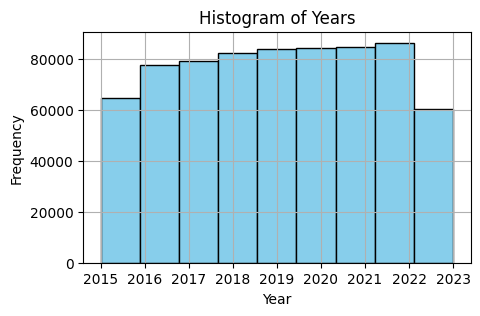

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with dates
# Let's create a sample DataFrame for demonstration
plotted_df = df.copy()

# Extract year from dates
plotted_df['year'] = plotted_df['period_end_date'].dt.year

# Plot histogram
plt.figure(figsize=(5, 3))
plt.hist(plotted_df['year'], bins=len(plotted_df['year'].unique()), color='skyblue', edgecolor='black')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Histogram of Years')
plt.grid(True)
plt.show()

### Separate aggregated values from values

In [6]:
# Renaming columns
df_renamed = df.rename(columns={"business_entity_doing_business_as_name": "brand", "legal_entity_name": "company", "ultimate_parent_legal_entity_name": "parent_company"})

In [7]:
all_brands = df_renamed[df_renamed["brand"] == "All Brands"]
brands = df_renamed[df_renamed["brand"] != "All Brands"]

### Check and fill na

In [8]:
# Check for na
for column in brands.columns:
    if len(brands[brands[column].isna()]):
        print(f"Column {column} contains na")

Column domicile_country_name contains na
Column primary_exchange_name contains na
Column followers contains na
Column pictures contains na
Column videos contains na
Column comments contains na
Column likes contains na


In [9]:
# Replace na of exchange with private
brands.loc[:, "primary_exchange_name"] = brands["primary_exchange_name"].fillna("Private")

In [10]:
nan_followers_count = len(brands[brands["followers"].isna()])
nan_followers_count

122582

### Find if NAs are intruisive or in external intervals

In [11]:
brands_names = brands["brand"].drop_duplicates()

In [12]:
na_intervals = []
columns = ["followers", "likes", "pictures", "videos"]

for column in columns:
    for brand in brands_names:
        brand_followers = brands[brands["brand"] == brand][["period_end_date", column]].sort_values("period_end_date")

        # Get the bounds of nan
        start_nan = brand_followers[brand_followers[column].isna()]["period_end_date"].min()
        end_nan = brand_followers[brand_followers[column].isna()]["period_end_date"].max()

        # Get the bounds of not nan
        start_not_nan = brand_followers[brand_followers[column].notna()]["period_end_date"].min()
        end_not_nan = brand_followers[brand_followers[column].notna()]["period_end_date"].max()

        if (pd.isna(start_nan) or pd.isna(end_nan))\
            or (start_nan < start_not_nan and end_nan < start_not_nan)\
            or (start_nan > end_not_nan or end_nan > end_not_nan):
            na_intervals.append({
                "brand": brand,
                "column": column,
                "start": start_nan,
                "end": end_nan,
                "intruisive_na": False
            })
        else:
            na_intervals.append({
                "brand": brand,
                "column": column,
                "start": start_nan,
                "end": end_nan,
                "intruisive_na": True
            })
        

In [14]:
na_intervals_df = pd.DataFrame(na_intervals)

In [42]:
na_intervals_df

,brand,column,start,end,intruisive_na
0,Hering,followers,2015-01-03,2015-04-25,False
1,Longines,followers,2015-01-03,2018-06-02,False
2,3.1 Phillip Lim,followers,2015-01-03,2015-05-02,False
3,Quorn,followers,2015-01-03,2018-03-03,False
4,Proenza Schouler,followers,NaT,NaT,False
...,...,...,...,...,...
2815,Sculptra,videos,NaT,NaT,False
2816,Temu,videos,2022-09-03,2023-02-04,False
2817,Finding Unicorn,videos,NaT,NaT,False
2818,Pop Mart,videos,NaT,NaT,False


#### Check if missing values are the latest data

In [22]:
max_date = brands["period_end_date"].max()

In [41]:
na_intervals_df[na_intervals_df["end"] > max_date - pd.DateOffset(years=4)]["brand"].unique()

array(['Simmons', 'LP Building Products', 'East Bay', 'Bottega Veneta',
       "Carter's", 'Sperry', 'Serta', 'Nature Valley', 'Nautica',
       'Bobbi Brown', 'Anta', "OshKosh B'gosh", 'Kanebo',
       'Michelob Ultra', 'Skip Hop', 'Runnerspoint', 'Fashion Nova',
       'Modelo', 'Yoplait', 'Invisalign', 'CertainTeed', 'CCC Shoes',
       'John Frieda', 'Whiskas', 'Vegetarian Butcher', 'Tempur',
       'Breville', 'Schweppes', 'Becca', 'Sizeer', 'iRobot',
       'Ninja Kitchen', 'About You', 'Sensai', 'Izod', 'Restylane',
       'Ecovacs', "Beck's", 'Shark Home', 'Garden Gourmet', 'Revanesse',
       'Sol', 'Elemis', 'Hoegaarden', 'Bulgari Beauty', 'Carla Amorim',
       'Royal Building Products', 'The Meatless Farm', 'Tineco',
       'Roborock', 'Superdown', 'ORCA', 'Burberry Beauty',
       'Pure Farmland', 'Spaten', 'Dysport', 'Sculptra', 'Temu',
       'Finding Unicorn', 'Pop Mart', 'Rolife', 'Wahoo Fitness',
       'Belotero', 'My Shoes', 'Tonica Antarctica', 'Value Village',
   

In [41]:
intruisive_na_df = na_intervals_df[na_intervals_df["intruisive_na"] == True]
intruisive_na_df

,brand,column,start,end,intruisive_na


**=> No intrusive data found**

## Stocks

In [ ]:
import requests

API_KEY = "SUXSALQJDNMC5N1C"

# Function to fetch stock prices
def fetch_stock_prices(symbol):
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&q={symbol}&apikey={API_KEY}'
    
    try:
        response = requests.get(url)
        data = response.json()

        # Extract daily stock prices
        if 'Time Series (Daily)' in data:
            time_series = data['Time Series (Daily)']
            # Print the latest available stock price
            latest_date = max(time_series.keys())
            latest_price = time_series[latest_date]['4. close']
            print(f"Latest closing price for {symbol}: ${latest_price}")
        else:
            print("No data available for the given symbol.")
    
    except Exception as e:
        print("Error fetching data:", e)

# Example usage
fetch_stock_prices('LVMH Moet Hennessy Louis Vuitton SE')  # Replace 'AAPL' with the symbol of the stock you want to fetch

In [ ]:
import requests

def get_ticker_symbol(company_name):
    API_KEY = 'SUXSALQJDNMC5N1C'
    base_url = "https://www.alphavantage.co/query?"
    params = {
        "function": "SYMBOL_SEARCH",
        "keywords": company_name,
        "apikey": API_KEY
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    try:
        # Assuming the first result is the most relevant
        return data['bestMatches']
    except (IndexError, KeyError):
        return "Symbol not found"

# Example usage
company_name = 'LVMH Moet Hennessy Louis Vuitton SE'
print(get_ticker_symbol(company_name))

In [ ]:
fetch_stock_prices(get_ticker_symbol(company_name))

In [ ]:
import yfinance as yf

def get_stock_symbol(company_name):
    # Search for the company by its name
    company = yf.Ticker(company_name)
    
    # Get the stock symbol
    symbol = company
    return symbol

def fetch_market_data(company_name):
    # Get the stock symbol for the company
    symbol = get_stock_symbol(company_name)
    
    # Fetch market data for the company
    company_data = yf.download(symbol)
    return company_data

# Example usage
company_name = "LVMH Moet Hennessy Louis Vuitton SE"
company_data = fetch_market_data(company_name)
print(company_data)